In [3]:
#the file names mean nithig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

In [4]:
import pandas as pd

df = pd.read_csv('diabetes.csv')

# Assuming the last column contains the labels (adjust column name if needed)
label_column = 'Outcome'  # Update this to the correct column name in your dataset
X = df.drop(columns=[label_column])  # Drop the label column for t-SNE
labels = df[label_column].values
X=X.values

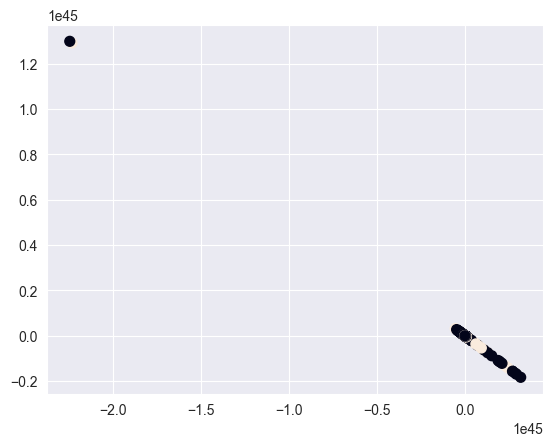

In [4]:
import my_tsne
import matplotlib.pyplot as plt
tsne = my_tsne.my_TSNE(0.6)
X_low = tsne.fit(X, 30, 2, 100)
plt.scatter(X_low[:, 0], X_low[:, 1], c=labels.astype(int), s=50, label='low')

In [1]:
import my_tsne

tsne = my_tsne.my_TSNE(0.6)

perps = [i for i in range(5, 50, 5)]
KLs = []
for p in perps:
    x_low = tsne.fit(X, p, 2, 100)
    KLs.append(tsne.get_KL())

In [2]:
print(KLs)

[np.float64(2186.9496396878258), np.float64(1656.1907104029085), np.float64(1168.3696728709656), np.float64(885.1931502496634), np.float64(783.5491574062114), np.float64(879.3613246325633), np.float64(662.5069832063324), np.float64(746.8180707045391), np.float64(687.0663369236426)]


Text(0, 0.5, 'kl divergence')

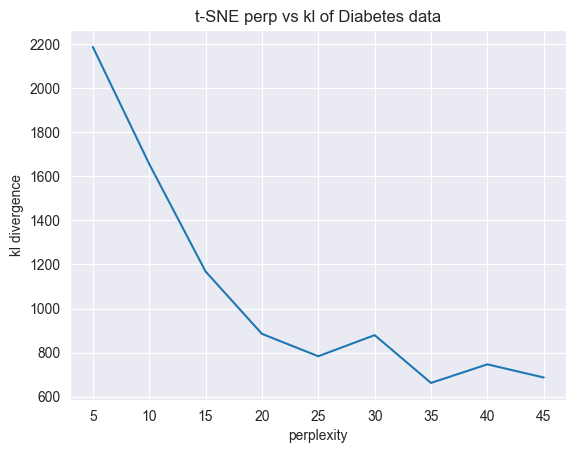

In [3]:
import matplotlib.pyplot as plt
plt.plot(perps, KLs)
plt.title("t-SNE perp vs kl of Diabetes data")
plt.xlabel("perplexity")
plt.ylabel("kl divergence")

In [5]:
import my_umap
umap = my_umap.my_UMAP(0.6)

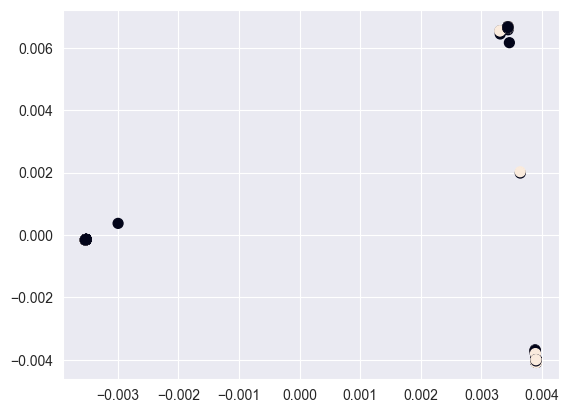

In [13]:
x_low = umap.fit(X, 100, 0.25, 2, 200)
plt.scatter(x_low[:, 0], x_low[:, 1], c=labels.astype(int), s=50, label='low')

In [12]:
neighbours = [i for i in range(5, 200, 10)]
CEs = []
for n in neighbours:
    x_low = umap.fit(X, n, 0.1, 2, 200)
    CEs.append(umap.get_CE())

/Users/shin/umap_testing/pythonProject1/.venv/lib/python3.13/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/shin/umap_testing/pythonProject1/.venv/lib/python3.13/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/shin/umap_testing/pythonProject1/.venv/lib/python3.13/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Text(0, 0.5, 'Cross entropy')

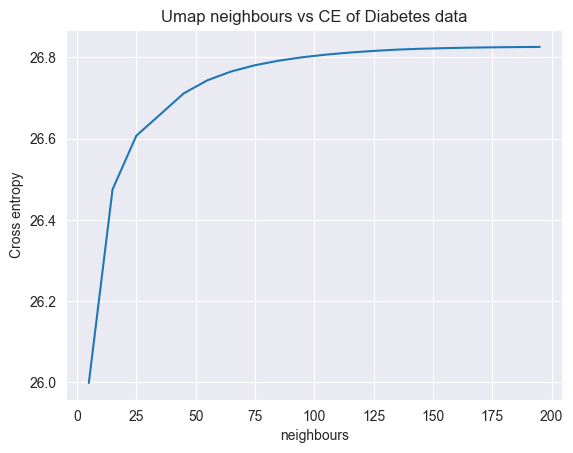

In [14]:
plt.plot(neighbours, CEs)
plt.title("Umap neighbours vs CE of Diabetes data")
plt.xlabel("neighbours")
plt.ylabel("Cross entropy")

In [18]:
umap = my_umap.my_UMAP(0.6)
expr = pd.read_csv("Cancer_Data.csv")  # Update this to the correct column name in your dataset
EXPR = expr.drop(columns=['diagnosis']).fillna(0) # Drop the label column for t-SNE
neighbours = [i for i in range(5, 200, 10)]
CEs = []
for n in neighbours:
    x_low = umap.fit(EXPR, n, 0.1, 2, 200)
    CEs.append(umap.get_CE())

/Users/shin/umap_testing/pythonProject1/.venv/lib/python3.13/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/shin/umap_testing/pythonProject1/.venv/lib/python3.13/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Text(0, 0.5, 'Cross entropy')

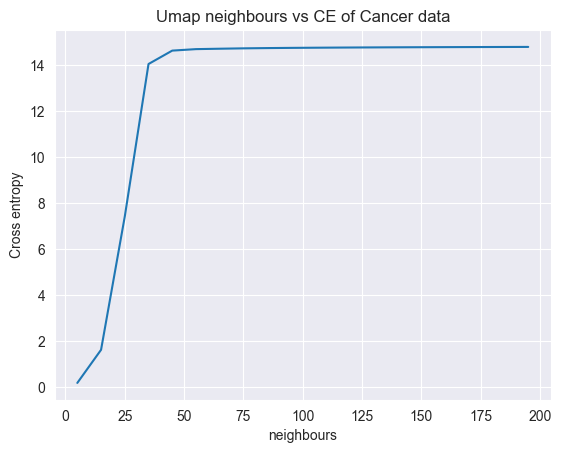

In [20]:
plt.plot(neighbours, CEs)
plt.title("Umap neighbours vs CE of Cancer data")
plt.xlabel("neighbours")
plt.ylabel("Cross entropy")